# Использую MLflow чтобы сохранять результаты экспериментов.

In [182]:
# !pip install influxdb

In [183]:
# pip install mlflow

In [43]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "29NfLast8608S6dxUNuJnNyqYQ1_36CtBkd17GHaKdA6mDw6N"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

     |████████████████████████████████| 745 kB 5.7 MB/s 
MLflow Tracking UI: https://3364-35-196-203-160.ngrok.io


# Первичная обработка основных признаков

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree 

# Pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, 
                                   LabelEncoder, MinMaxScaler)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Metrix
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score
from sklearn.metrics import (roc_curve, auc, roc_auc_score,
                             confusion_matrix, mean_squared_error)

# Other
from urllib.parse import urlparse
import itertools
from sklearn.datasets import load_iris
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

In [45]:
data = pd.read_csv("data.csv", encoding='latin1')

Цели для обработки данных:

*   Remove features associated with >85% missing values
*   Remove constant features
*   Remove duplicates features
*   Remove duplicate rows
*   Remove highly collinear features

# Вспомагательная функция для построения графиков:



In [46]:
# https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c
# Эта функция строит графики с учетом того, категориальный ли признак

def plot_feature(col_name, isContinuous, df): 
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

# Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

# Описание данных

**loan_amnt** - запрашиваемая у банка сумма для кредита \

**funded_amnt** - накопительная сумма \

**funded_amnt_inv** - накопительная сумма для инвестора \

**term** - на какой промежуток выдан кредит

**int_rate** - процентная ставка \

**installment** - первоначальный взнос \

**grade** - оценка кредитного риска

**emp_title** - профессия

**emp_length** - опыт работы

**home_ownership** - тип жилья

**annual_inc** - годовые доходы \

**verification_status** - статус верификации

**issue_d** - месяц в который получено финансирование

**purpose** - цель

**addr_state** - кто выдает кредит (гос сторона)

**dti** - это процент ежемесячного валового дохода потребителя, который идет на выплату долгов \

**delinq_2yrs** - просрочка платежей более чем на 30 дней за последние два года \

**earliest_cr_line** - месяц открытия самой ранней кредитной истории

**inq_last_6mths** - количество обращений кредитора(то есть Банка) в бюро кредитных историй, если клиент ходит по разным банкам и просит кредиты, то это говорит, что этому клиенту либо отказывают, либо он решил набрать везде кредитов. Как правило это негативно влияет \

**open_acc** - это количество открытых кредитов

**revol_bal** - общий оборотный остаток

**revol_util** - доля утилизации. Клиенту выдали кредитную карту с лимитом 100 рублей, он уже потратил 40 рублей, revol_util будет равен 40/100 = 0.4

**total_acc** - видимо все кредиты и активные, и закрытые

**out_prncp** - оставшаяся непогашенная сумма

**total_pymnt** - полученные на сегодня платежи

**loan_status** - текущий статус кредита (закрыт не закрыт)

**risk** - выадем не выдаем

## Здесь же попробуем создать новые признаки

Добавила хотя бы один признак: средняя выплата в месяц, без учета процентной ставки

In [47]:
data['term_month'] = data['term'].str.split().str[0]
data['term_month'] = pd.to_numeric(data['term_month'])

data = data.assign(mean_payment = data['loan_amnt'] / data['term_month'])

data.drop('term_month', axis=1,  inplace=True) 

# Разведочный анализ данных и обработка

Сразу удалим все дубликаты:

In [48]:
data.drop_duplicates(inplace= True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310704 entries, 0 to 310703
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   310704 non-null  int64  
 1   loan_amnt            310704 non-null  int64  
 2   funded_amnt          310704 non-null  int64  
 3   funded_amnt_inv      310704 non-null  float64
 4   term                 310704 non-null  object 
 5   int_rate             310704 non-null  float64
 6   installment          310704 non-null  float64
 7   grade                310704 non-null  object 
 8   emp_title            281139 non-null  object 
 9   emp_length           288089 non-null  object 
 10  home_ownership       310704 non-null  object 
 11  annual_inc           310704 non-null  float64
 12  verification_status  310704 non-null  object 
 13  issue_d              310704 non-null  object 
 14  purpose              310704 non-null  object 
 15  addr_state       

Посмотрим на пропущенные данные:

In [50]:
data.isna().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_title              29565
emp_length             22615
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                      148
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               213
total_acc                  0
out_prncp                  0
total_pymnt                0
loan_status                0
risk                       0
mean_payment               0
dtype: int64

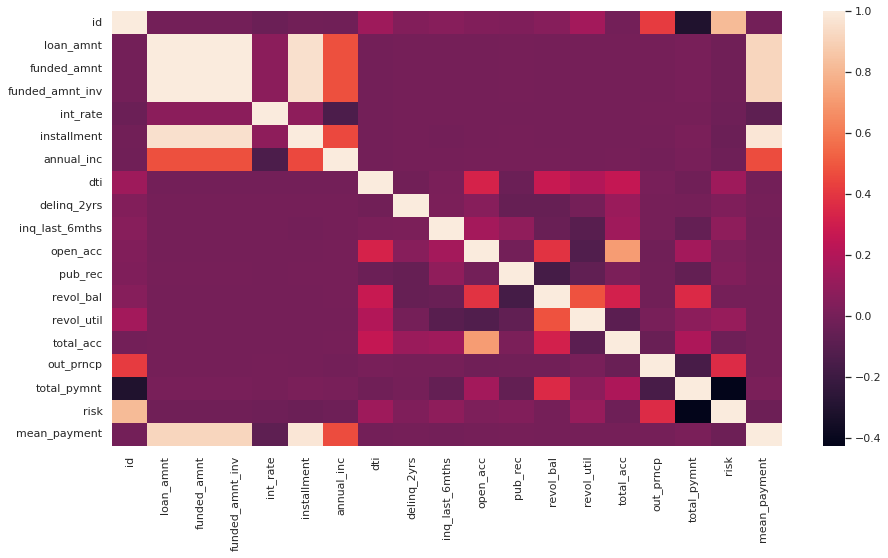

In [51]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

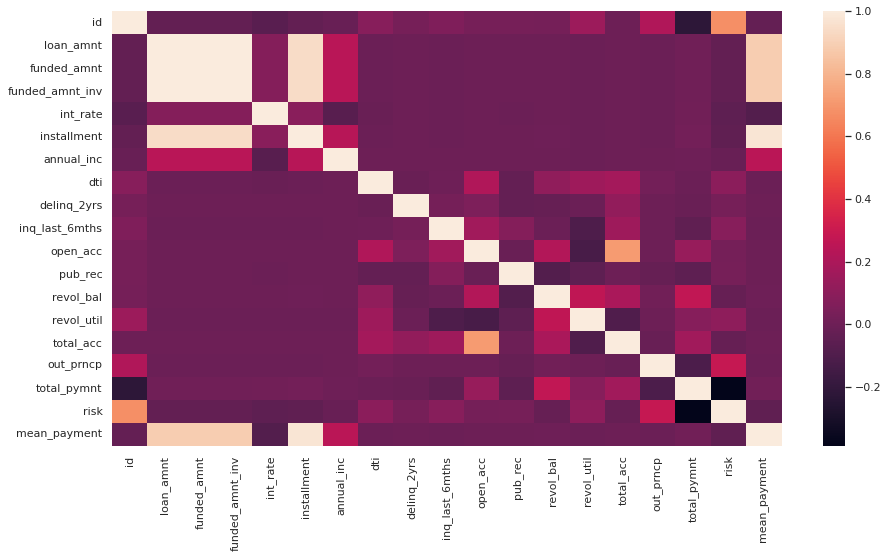

In [52]:
corr_matrix = data.corr(method = 'pearson')

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

In [53]:
data.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,risk,mean_payment
count,3.107040e+05,310704.000000,310704.000000,310704.000000,310704.000000,310704.000000,3.107040e+05,310556.000000,310704.000000,310703.000000,310704.000000,310704.000000,3.107040e+05,310491.000000,310704.000000,310704.000000,310704.000000,310704.000000,310704.000000
mean,6.204661e+05,15518.606133,15518.606133,15511.817884,12.565801,452.838937,8.053998e+04,19.020776,0.338029,0.607374,11.882889,0.248008,1.605273e+04,48.495109,24.916757,723.861865,13430.483430,0.333655,360.293718
std,3.928862e+05,9196.532109,9196.532109,9195.219672,4.702061,264.514016,9.286294e+04,12.339552,0.921206,0.888372,5.793843,0.671583,2.322824e+04,24.812508,12.312579,3602.732652,10010.944733,0.471519,214.542515
min,1.000000e+00,1000.000000,1000.000000,725.000000,5.320000,14.770000,0.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,27.777778
25%,7.767675e+04,8275.000000,8275.000000,8250.000000,8.810000,259.420000,4.800000e+04,12.070000,0.000000,0.000000,8.000000,0.000000,5.515750e+03,29.600000,16.000000,0.000000,5783.218540,0.000000,200.000000
50%,7.586255e+05,14000.000000,14000.000000,14000.000000,11.990000,387.550000,6.720000e+04,18.190000,0.000000,0.000000,11.000000,0.000000,1.059000e+04,48.000000,23.000000,0.000000,10741.860000,0.000000,305.555556
75%,9.708992e+05,20800.000000,20800.000000,20800.000000,15.310000,602.950000,9.500000e+04,25.080000,0.000000,1.000000,15.000000,0.000000,1.908500e+04,67.300000,32.000000,0.000000,18592.573820,1.000000,466.666667
max,1.048575e+06,40000.000000,40000.000000,40000.000000,30.990000,1618.240000,9.757200e+06,999.000000,21.000000,5.000000,81.000000,86.000000,1.044210e+06,182.800000,176.000000,40000.000000,59808.262090,1.000000,1111.111111


### Посмотрим на всякие диаграмы рассеяния (многомерный анализ)

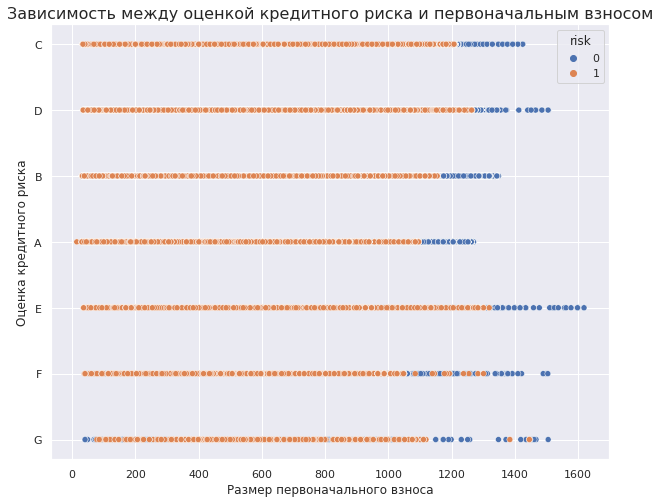

In [54]:
from IPython.core.pylabtools import figsize

sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

markers = {"0": "s", "1": "X"}
plt.title('Зависимость между оценкой кредитного риска и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Оценка кредитного риска', size=12)
sns.scatterplot(x='installment', y='grade', data=data, hue='risk', markers=markers, palette='deep')
plt.show()

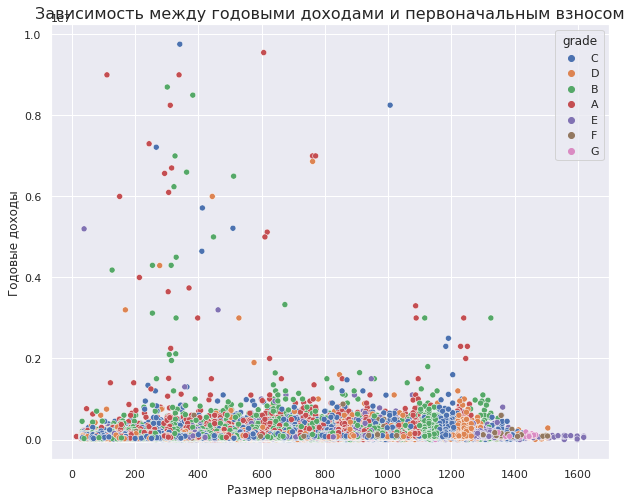

In [55]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между годовыми доходами и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Годовые доходы', size=12)

sns.scatterplot(x='installment', y='annual_inc', data=data, hue='grade', palette='deep')
plt.show()

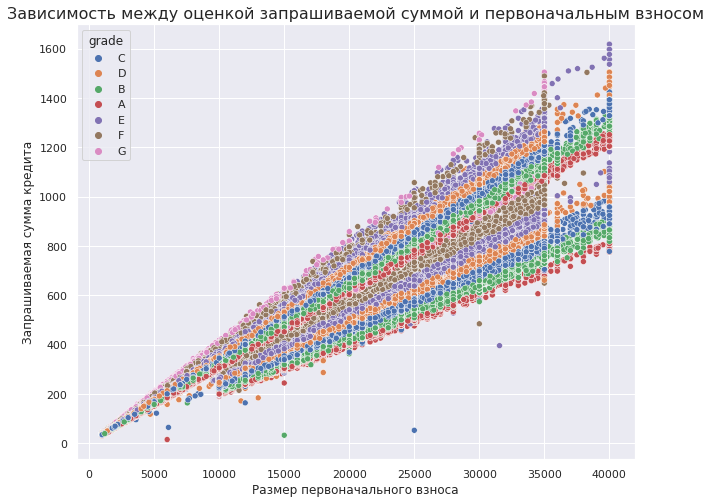

In [56]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между оценкой запрашиваемой суммой и первоначальным взносом', size=16)
plt.xlabel('Размер первоначального взноса', size=12)
plt.ylabel('Запрашиваемая сумма кредита', size=12)

sns.scatterplot(x='loan_amnt', y='installment', data=data, hue='grade', palette='deep')
plt.show()

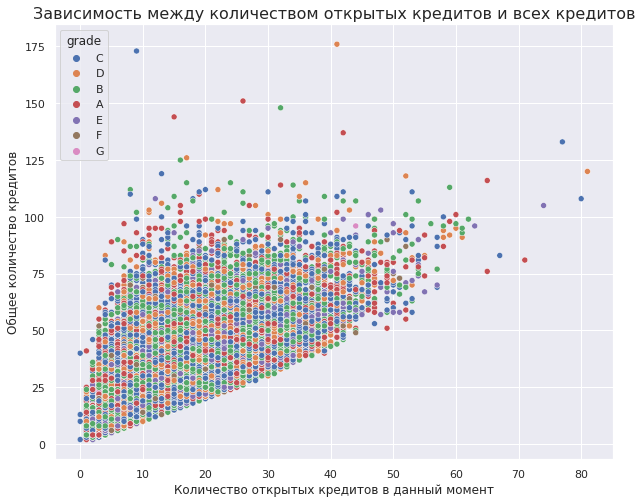

In [57]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между количеством открытых кредитов и всех кредитов', size=16)
plt.xlabel('Количество открытых кредитов в данный момент', size=12)
plt.ylabel('Общее количество кредитов', size=12)

sns.scatterplot(x='open_acc', y='total_acc', data=data, hue='grade', palette='deep')
plt.show()

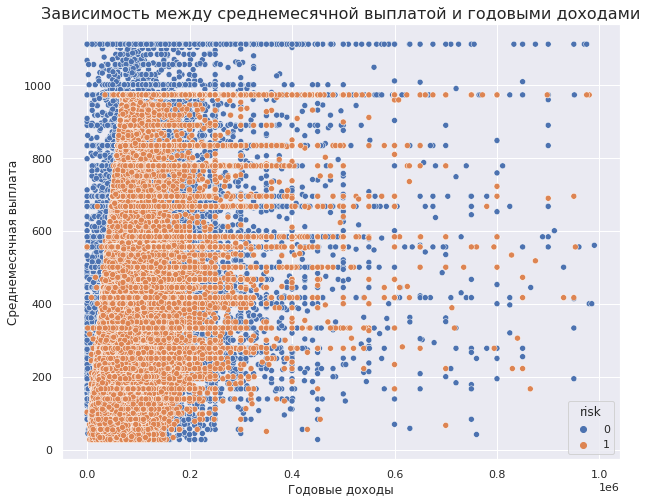

In [58]:
sns.set_style('darkgrid')

plt.figure(figsize=(10, 8))

plt.title('Зависимость между среднемесячной выплатой и годовыми доходами', size=16)
plt.xlabel('Годовые доходы', size=12)
plt.ylabel('Среднемесячная выплата', size=12)

sns.scatterplot(x=data[data['annual_inc'] < 1000000]['annual_inc'], y='mean_payment', data=data, hue='risk', palette='deep')
plt.show()

### Далее пройду по всем признакам и рассмотрю их детально.

### risk

In [59]:
data['risk'].value_counts()

0    207036
1    103668
Name: risk, dtype: int64

Важно было убедиться, что у нас достаточное количество дефолтов для исследования и разница между признаками не превышает 90%.

### loan_amnt

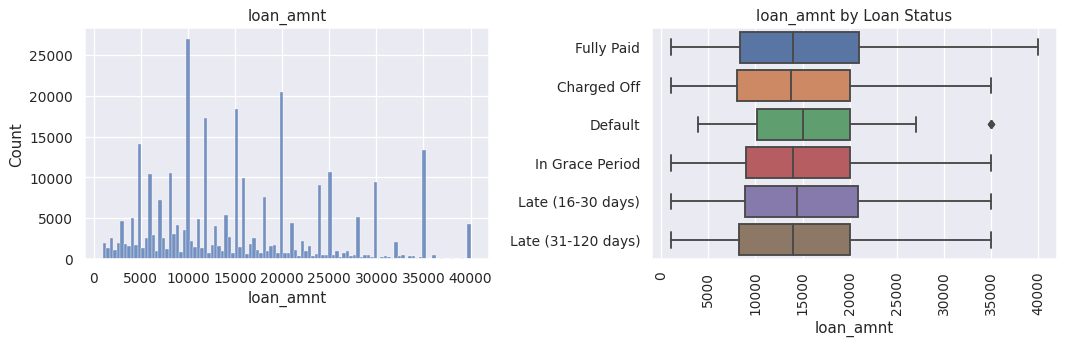

In [60]:
plot_feature('loan_amnt', True, data)

Сложно тут оценивать выбросы, потому что в принципе сумма займа не должна сильно зависеть от вероятности дефолта, поэтому пока оставлю так. Возможно, в будущем для рассмотрения стоит оставить только Fully Paid и Charged Off.

In [61]:
data = data.loc[(data['loan_status'].isin(['Fully Paid', 'Charged Off']))]

### annual_inc

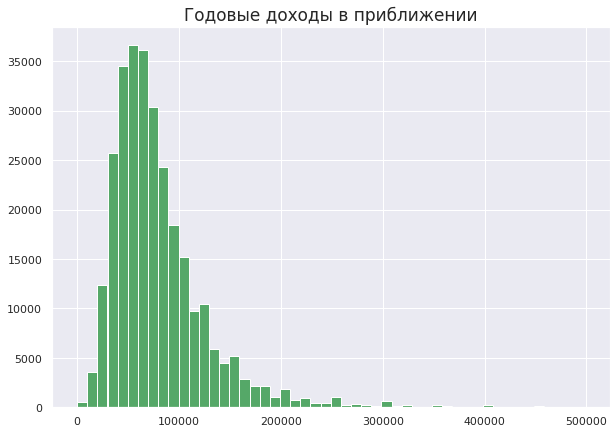

In [62]:
data[data['annual_inc'] < 500000]['annual_inc'].hist(bins=50, figsize=(10, 7), color='g')

plt.title('Годовые доходы в приближении', size = 17)
plt.show()

### int_rate

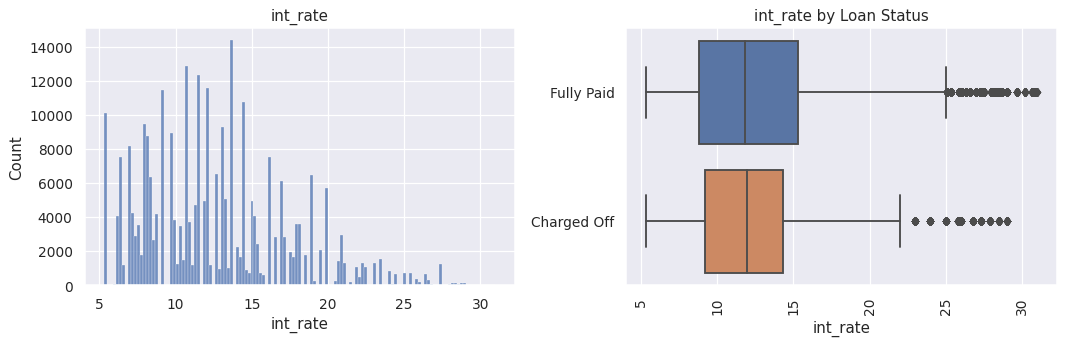

In [63]:
plot_feature('int_rate', True, data)

### installment

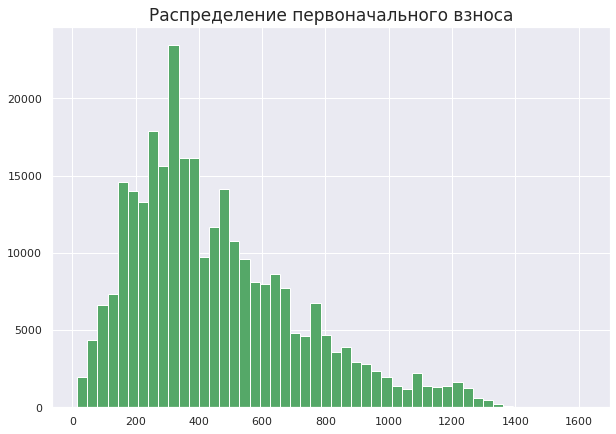

In [64]:
data['installment'].hist(color = 'g', bins=50, figsize=(10, 7))

plt.title('Распределение первоначального взноса', size = 17)
plt.show()

### funded_amnt и funded_amnt_inv

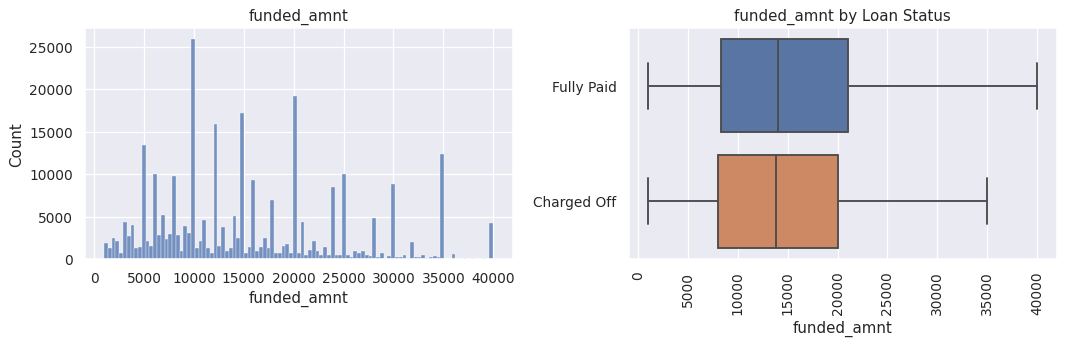

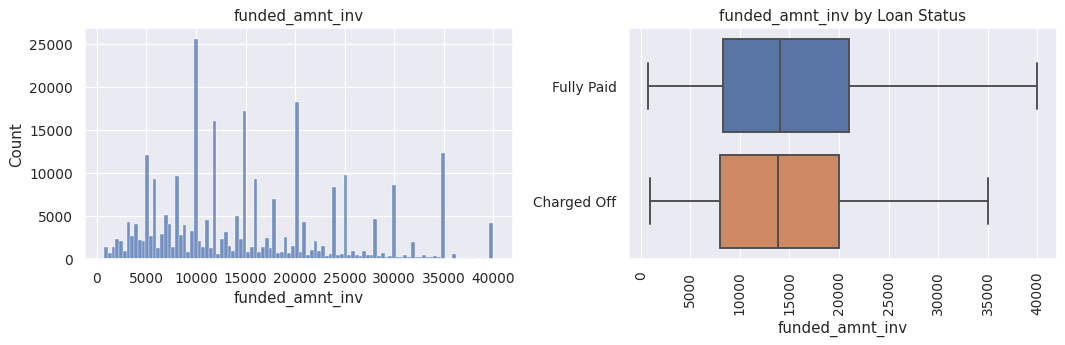

In [65]:
plot_feature('funded_amnt', True, data)
plot_feature('funded_amnt_inv', True, data)

Не уверена, нужны ли нам два настолько близких признака. Я бы оставила только funded_amnt, потому что по ощущениям данные там чуть более полные.

In [66]:
data.drop('funded_amnt_inv', axis=1,  inplace=True) 

### pub_rec

In [67]:
data.drop('pub_rec', axis=1, inplace=True) 
# не поняли что это за признак

### emp_title

In [68]:
data['emp_title'].value_counts()

Teacher                         5309
Manager                         4609
Owner                           2539
Registered Nurse                2261
Driver                          2032
                                ... 
Lineman/Troubleman                 1
Senior SEC Reporting Analyst       1
surgery scheduler                  1
PBX Operator,V.A.                  1
Economist                          1
Name: emp_title, Length: 86769, dtype: int64

Слишком много уникальных профессий и вероятнее всего они не отражают ничего дельного, поэтому этот признак можно удалить.

In [69]:
data.drop('emp_title', axis=1, inplace=True) 

### home_ownership

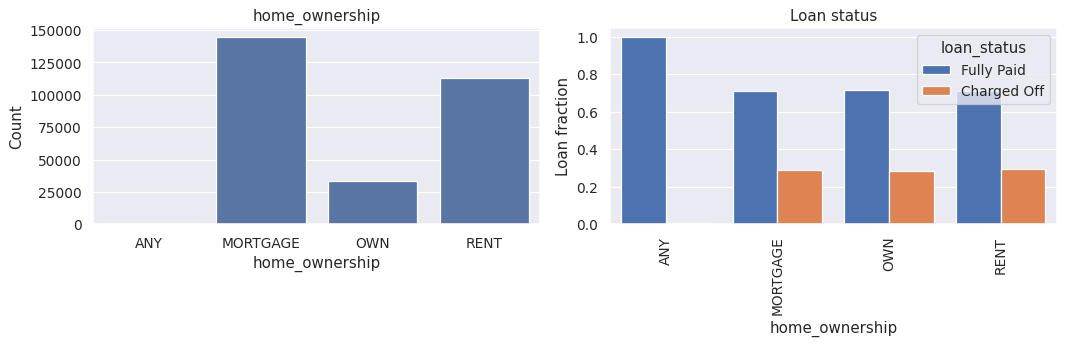

In [70]:
plot_feature('home_ownership', False, data)

Возможно на категориальных данных, которых сравнительно меньше остальных, модель будет сильно переобучаться, поэтому я думаю удалю "ANY"

In [71]:
data = data.loc[data['home_ownership'] != "ANY"]
#  data = data.drop(np.where(data['home_ownership'] == "ANY")[0])

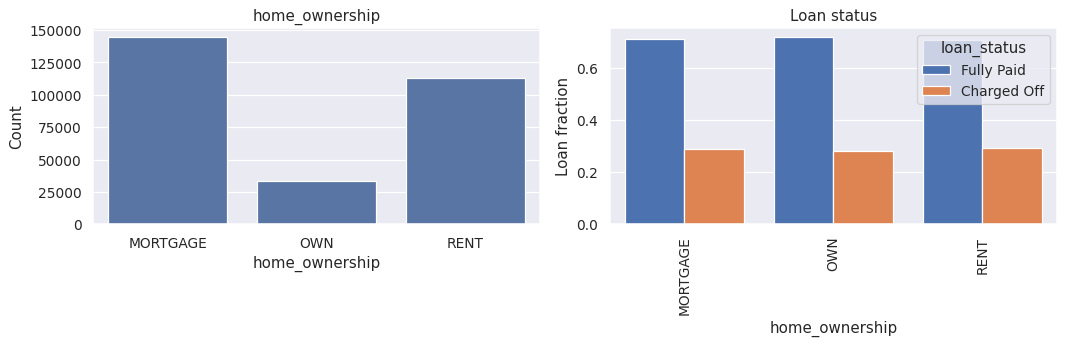

In [72]:
plot_feature('home_ownership', False, data)

### emp_length

Так как меньше 10% признаков в emp_title и  emp_lenght пропущены, не будем выкидывать эти признаки, а просто заменим значения пустой строкой.

In [73]:
data.fillna(value={'emp_title': ''}, inplace = True)

Ниже с **emp_length** надо подумать, может лучше сделать просто количество лет и не делать это категориальным признаком

In [74]:
data['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [75]:
data.fillna(value={'emp_length': 'No'}, inplace = True)

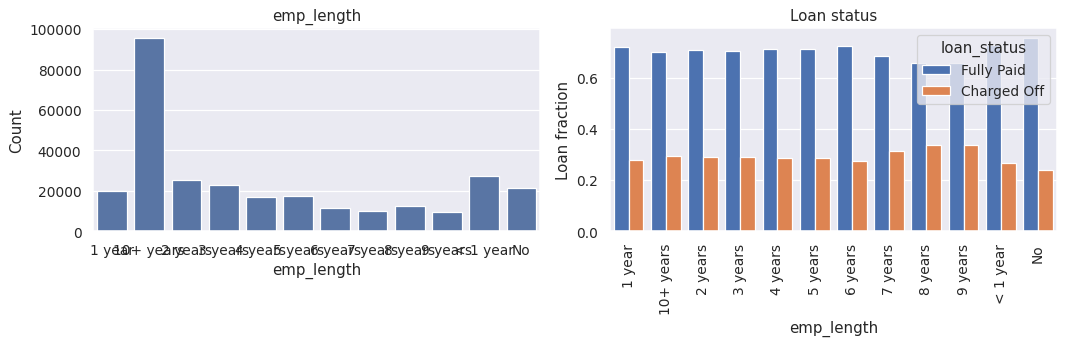

In [76]:
plot_feature('emp_length', False, data)

### **dti**

Мне кажется один из важнейших признаков который должен очень сильно коррелировать - это процент с дохода, который идет на выплату. Очень красивое распределение

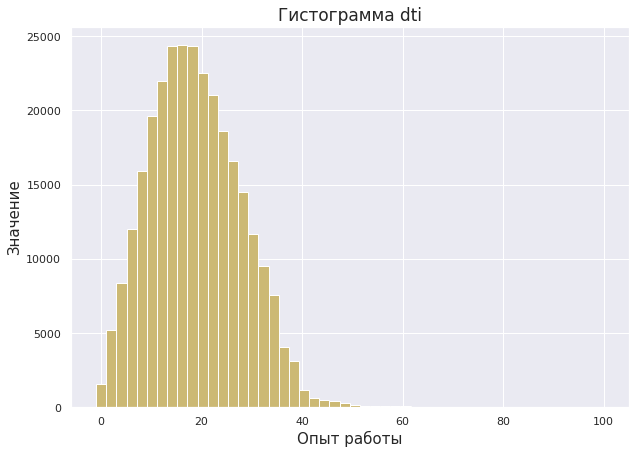

In [77]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

In [78]:
data.fillna(value={'dti': 0, 'revol_util': 0}, inplace = True)

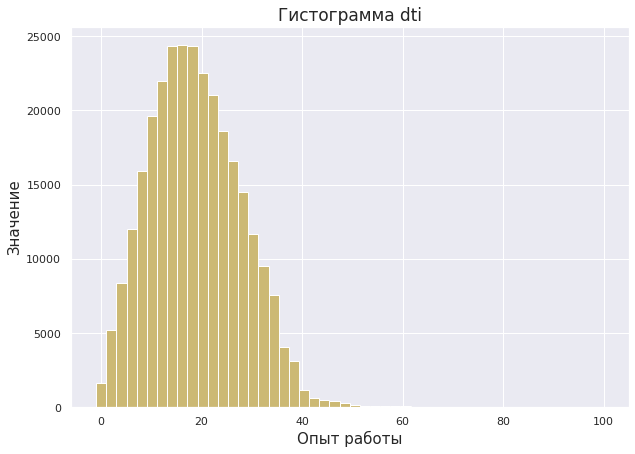

In [79]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Заполнение нулями ничего сильно не повредило, поэтому супер.

### **grade**

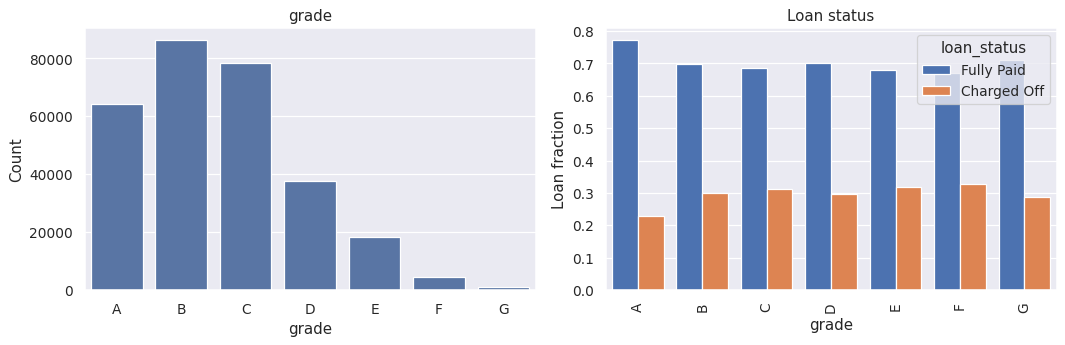

In [80]:
plot_feature('grade', False, data)

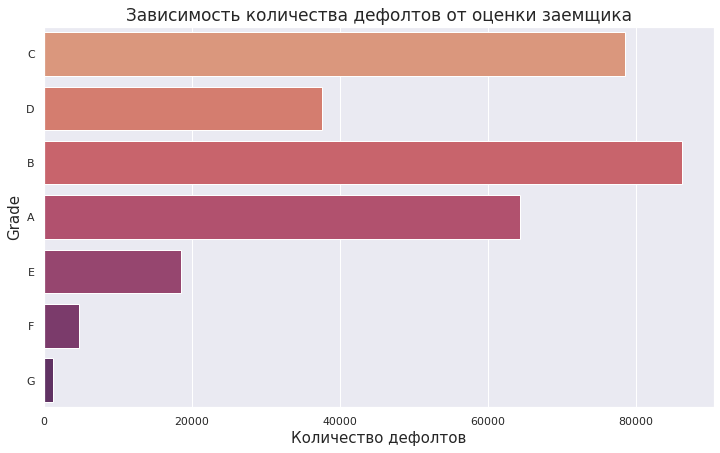

In [81]:
plt.figure(figsize=(12, 7))
sns.countplot(data = data, y = data['grade'], palette="flare")

plt.title('Зависимость количества дефолтов от оценки заемщика', size = 17)
plt.xlabel('Количество дефолтов', size = 15)
plt.ylabel('Grade', size = 15)
plt.show()

### **issue_d** и **earliest_cr_line**

Два признака с датами, которые возможно стоит перевести в data type, либо я вычитала что можно оставить тольк месяц, из-за того что мы работаем с данными всего за пару лет. (И перевести в категориальные признаки)

In [82]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Mar-16', 'Feb-16', 'Jan-16',
       'Nov-15', 'Dec-15', 'Oct-15'], dtype=object)

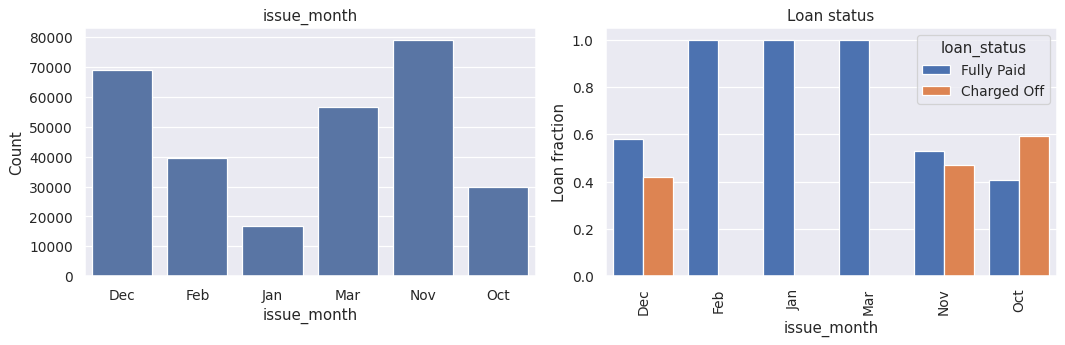

In [83]:
data['issue_month'] = pd.Series(data.issue_d).str.replace(r'-\d+', '')

data.drop('issue_d', axis=1, inplace=True) 
plot_feature('issue_month', False, data)

Пока получается не очень понятно, почему такое распределение по выплатам в зависимости от месяца...

In [84]:
# data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')
# data['earliest_cr_line'] = pd.to_datetime(data['issue_d'], format='%b-%y')

Пока непонятно, как это может помочь, не буду строить график из-за слишком многого количества признаков, но возможно они сойдут за хорошие категориальные.

In [85]:
data['earliest_cr_line']

0         Jan-12
1         Jun-09
2         Feb-99
3         Dec-03
4         Oct-97
           ...  
310352    Nov-97
310353    Sep-05
310354    Aug-02
310355    Nov-92
310356    Aug-06
Name: earliest_cr_line, Length: 290961, dtype: object

In [86]:
data['earliest_cr_year'] = data.earliest_cr_line.str.replace(r'\w+-', '').astype(np.int)

### **loan_status**

Что-то я потеряла, где я этот признак уже обрабатывала, но повторюсь, что я оставила только два типа: выплачено или нет.

In [87]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

### **purpose**

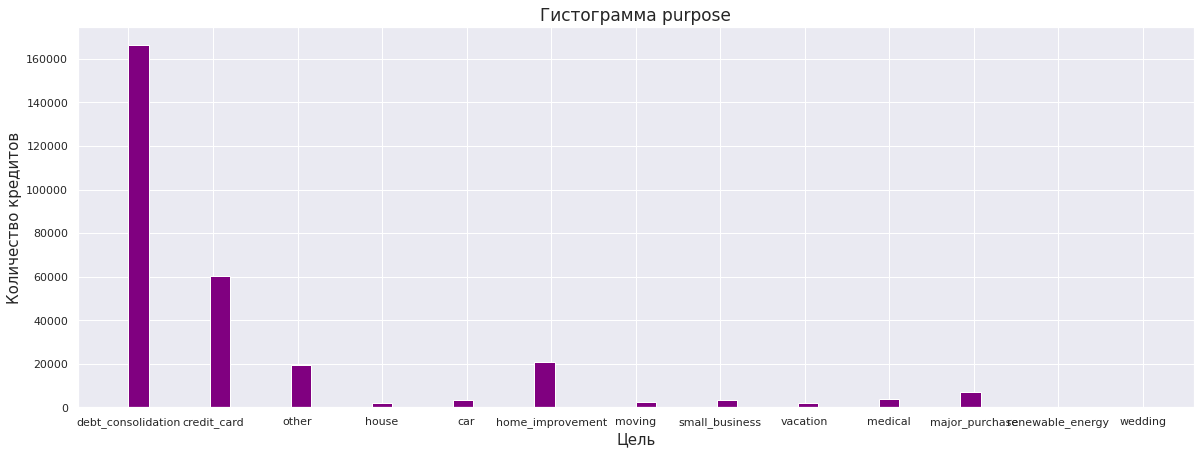

In [88]:
plt.ticklabel_format(style='plain')
data['purpose'].hist(bins=50, color='purple', figsize=(20, 7))

plt.title('Гистограмма purpose', size = 17)
plt.xlabel('Цель', size = 15)
plt.ylabel('Количество кредитов', size = 15)
plt.show()

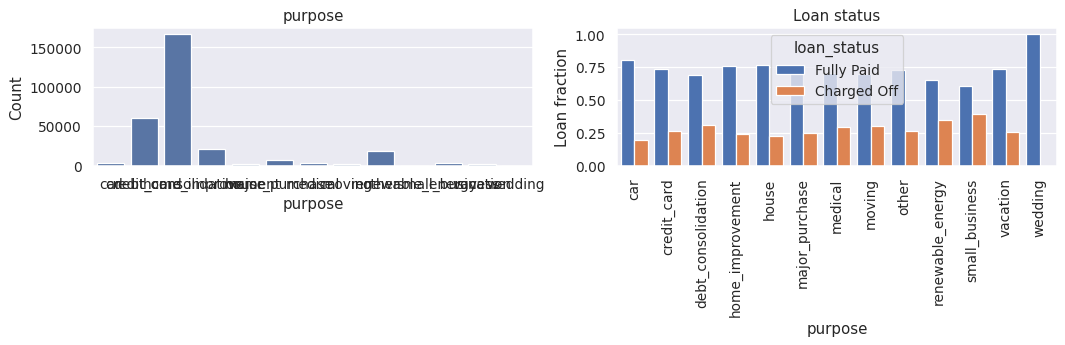

In [89]:
plot_feature('purpose', False, data)

In [90]:
data['purpose'].value_counts()

debt_consolidation    166400
credit_card            60272
home_improvement       20907
other                  19426
major_purchase          7128
medical                 3777
car                     3252
small_business          3182
moving                  2276
vacation                2161
house                   1975
renewable_energy         203
wedding                    2
Name: purpose, dtype: int64

### **verification_status**

In [91]:
data['verification_status']

0            Not Verified
1         Source Verified
2         Source Verified
3         Source Verified
4            Not Verified
               ...       
310352           Verified
310353       Not Verified
310354    Source Verified
310355           Verified
310356    Source Verified
Name: verification_status, Length: 290961, dtype: object

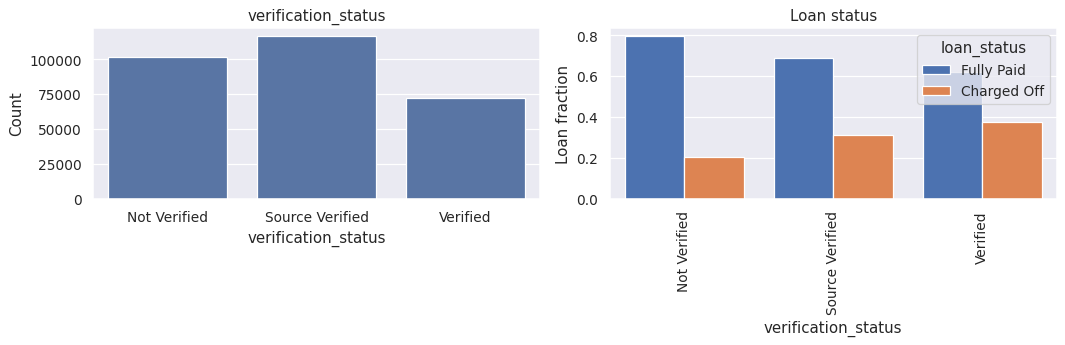

In [92]:
plot_feature('verification_status', False, data)

Очень странно, что у неверефицированных намного больший процент успешных выплат, хотя ожидается наоборот.

### **term**

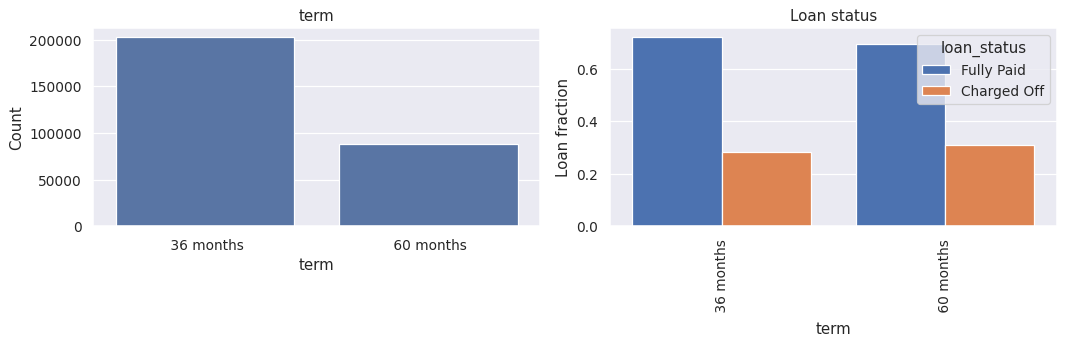

In [93]:
plot_feature('term', False, data)

Ничего особенного

### **addr_state**

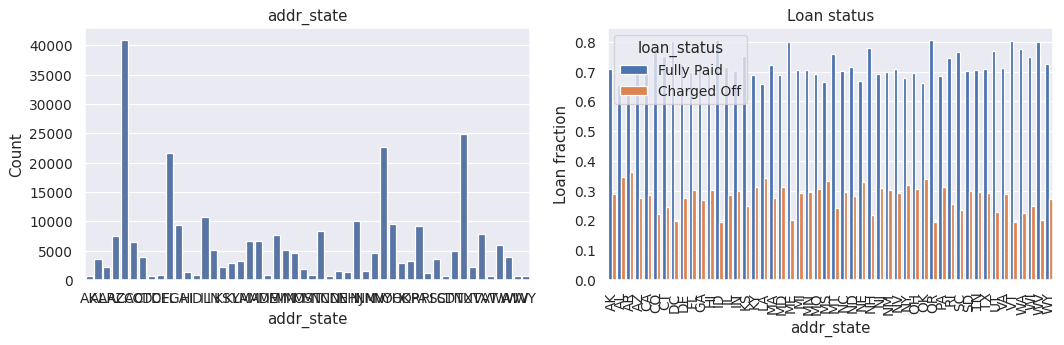

In [94]:
plot_feature('addr_state', False, data)

Есть где разгуляться, хорошо видно зависимости от региона в погашении кредита.

### **delinq_2yrs** and **inq_last_6mths**

Не могу придумать, как это может помочь, поэтому удалю данные.

In [95]:
data.drop('delinq_2yrs', axis=1, inplace=True) 

In [96]:
data.drop('inq_last_6mths', axis=1, inplace=True) 

### **open_acc**

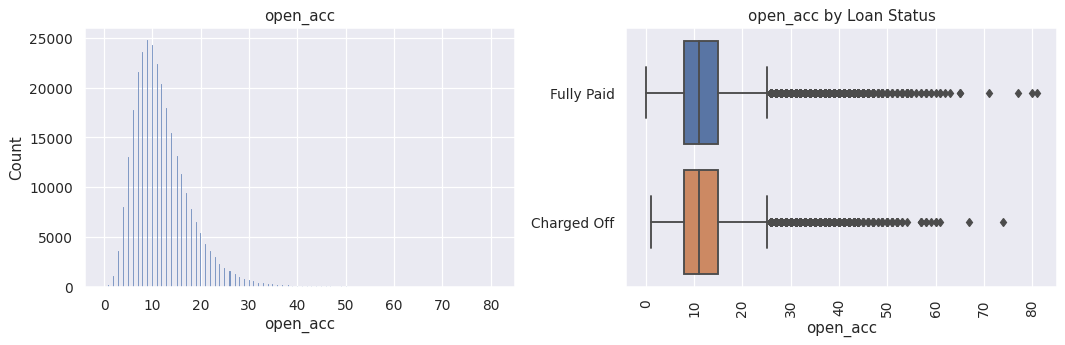

In [97]:
plot_feature('open_acc', True, data)

### **revol_util**

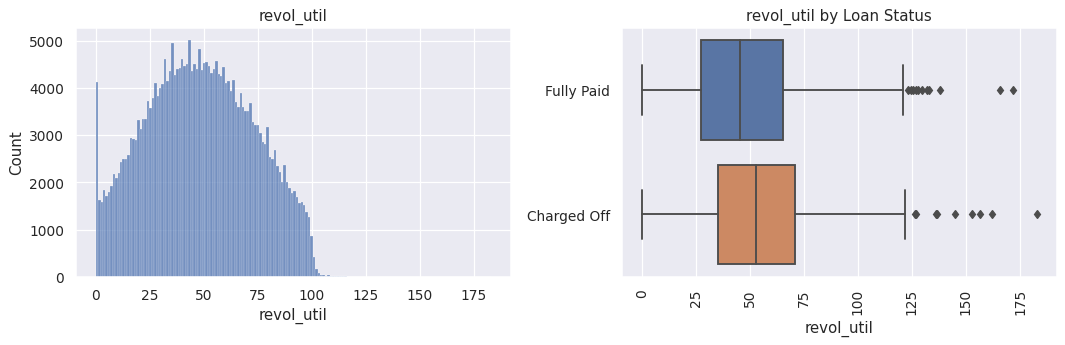

In [98]:
plot_feature('revol_util', True, data)

### **total_acc**

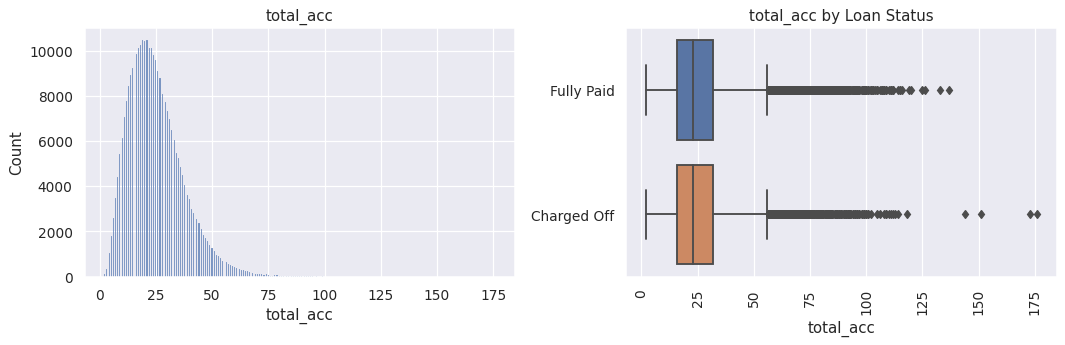

In [99]:
plot_feature('total_acc', True, data)

### **out_prncp**

In [100]:
data['out_prncp']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
310352    0.0
310353    0.0
310354    0.0
310355    0.0
310356    0.0
Name: out_prncp, Length: 290961, dtype: float64

Долго не могла понять что произошло, но оказалось что когда я оставила только два типа статусов: выплачено и нет, то все данные в которых был еще какой-то остаток удалились. Пока что я не планирую оставлять больше двух статусов, поэтому этот признак можно полностью удалить.

In [101]:
data.drop('out_prncp', axis=1, inplace=True) 

### **total_pymnt**

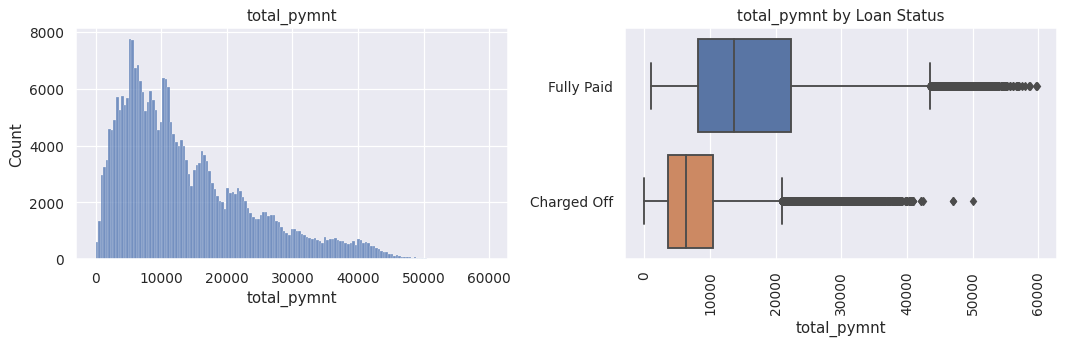

In [102]:
plot_feature('total_pymnt', True, data)

In [103]:
data.drop('total_pymnt', axis=1, inplace=True) 

### **ID**

In [104]:
data.drop('id', axis=1, inplace=True) 

## Итог обработки всех признаков:

Финально посмотрим на матрицу корреляции после обработки всех признаков:

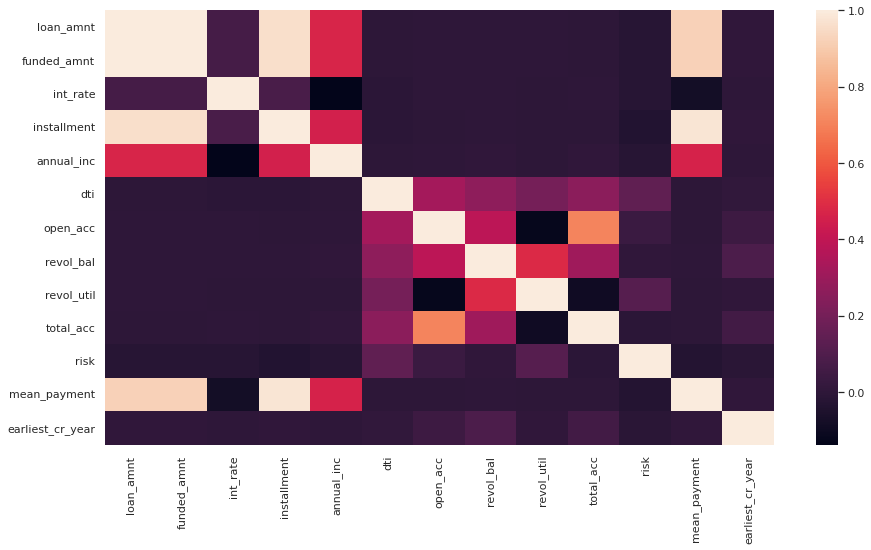

In [105]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

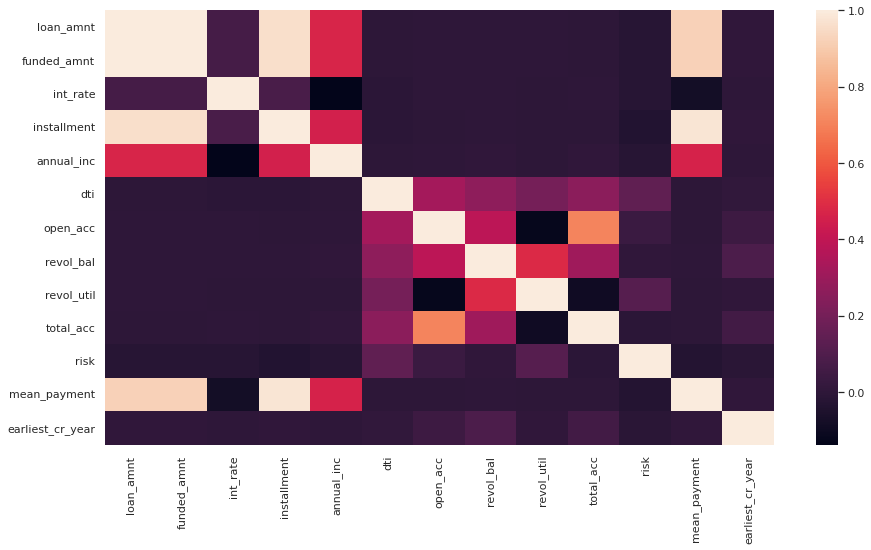

In [106]:
# Without delinq_2yrs

corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

## Хи-квадрат

In [107]:
data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,loan_status,risk,mean_payment,issue_month,earliest_cr_year
0,2500,2500,36 months,13.56,84.92,C,10+ years,RENT,55000.0,Not Verified,...,Jan-12,11,15603,37.0,19,Fully Paid,0,69.444444,Dec,12
1,30000,30000,60 months,18.94,777.23,D,10+ years,MORTGAGE,90000.0,Source Verified,...,Jun-09,18,34971,64.5,37,Fully Paid,0,500.000000,Dec,9
2,5000,5000,36 months,17.97,180.69,D,6 years,MORTGAGE,59280.0,Source Verified,...,Feb-99,9,25416,29.9,19,Fully Paid,0,138.888889,Dec,99
3,4000,4000,36 months,18.94,146.51,D,10+ years,MORTGAGE,92000.0,Source Verified,...,Dec-03,12,4472,15.3,25,Fully Paid,0,111.111111,Dec,3
4,30000,30000,60 months,16.14,731.78,C,10+ years,MORTGAGE,57250.0,Not Verified,...,Oct-97,21,36812,65.7,37,Fully Paid,0,500.000000,Dec,97


In [108]:
from scipy.stats import chi2, chi2_contingency
import matplotlib.pyplot as plt

In [109]:
chisqt = pd.crosstab(data.grade[205000:210000], data.risk, margins=True)
print(chisqt)

risk      0     1   All
grade                  
A       327   581   908
B       506   978  1484
C       475   975  1450
D       252   393   645
E       152   217   369
F        56    67   123
G        14     7    21
All    1782  3218  5000


In [110]:
value = np.array([chisqt[0][0:4].values,
                  chisqt[1][0:4].values])

value

array([[327, 506, 475, 252],
       [581, 978, 975, 393]])

In [111]:
answer = chi2_contingency(value)
print("Статистическое значение: ", answer[0])
print("P - значение: ", answer[1])
print("Степень свободы: ", answer[2])

Статистическое значение:  8.759584904443011
P - значение:  0.03266414812276088
Степень свободы:  3


Я конечно здесь ОЧЕНЬ искусственно подобрала данные для проверки, но хотя бы что-то для начала, разобралась как делать, подробнее посмотрю позже.

# Расчет IV и преобразование WOE


In [167]:
# Преобразование WOE

def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [168]:
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical = data.select_dtypes(include=['object']).columns.tolist()

In [169]:
# Делим интервальные переменные на бины

for feature in numeric_features:
    data[feature + '_bin'] = pd.qcut(data[feature], 5, duplicates='drop')
    data[feature + '_bin'] = data[feature + '_bin'].cat.add_categories("0-0").fillna("0-0")

for feature in categorical:
    data[feature] = data[feature].fillna("0-0") 

In [170]:
numeric_features.remove('risk')

In [171]:
categorical.remove('loan_status')

In [203]:
# Разделим на трейн и тест выборку 

train, test = train_test_split(data, test_size=0.3, random_state=17, stratify=data['risk'])

In [173]:
train['risk'].describe()

count    203672.000000
mean          0.289313
std           0.453445
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: risk, dtype: float64

In [174]:
test['risk'].describe()

count    87289.000000
mean         0.289315
std          0.453447
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: risk, dtype: float64

In [175]:
scorecard = pd.DataFrame()

In [204]:
print('Значения Information value для численных признаков:')


for feature in numeric_features:
    
    df, iv = calculate_woe_iv(train, feature + '_bin', 'risk')
    df['feature'] = feature

    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+ '_' + feature})
    
    train = train.drop(columns = [feature, feature + '_bin', 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})

    
    test = test.drop(columns = [feature, feature + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
    scorecard = scorecard.append(df[['feature', 'Value', 'WoE']])
    
    
    print(feature, ':', iv)

Значения Information value для численных признаков:
funded_amnt : 0.008261883083565394
int_rate : 0.04018526880751902
installment : 0.010955736992924105
annual_inc : 0.0038160534832015437
dti : 0.09086239554965159
open_acc : 0.0060738633407392785
revol_bal : 0.0044576841347923205
revol_util : 0.07134225979931966
total_acc : 0.0007304761739183441
earliest_cr_year : 0.002101132127287776


In [205]:
print('Значения Information value для категориальных признаков:')

for feature in categorical:
    df, iv = calculate_woe_iv(train, feature , 'risk')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})
    test = test.drop(columns = [feature, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])

   
    print(feature, ':', iv)

Значения Information value для категориальных признаков:
term : 0.0034210482769737125
grade : 0.026464424493455558
home_ownership : 0.0001917738345476871
purpose : 0.020983325169367326
addr_state : 0.024436461398067086
issue_month : 0.4694470788733911


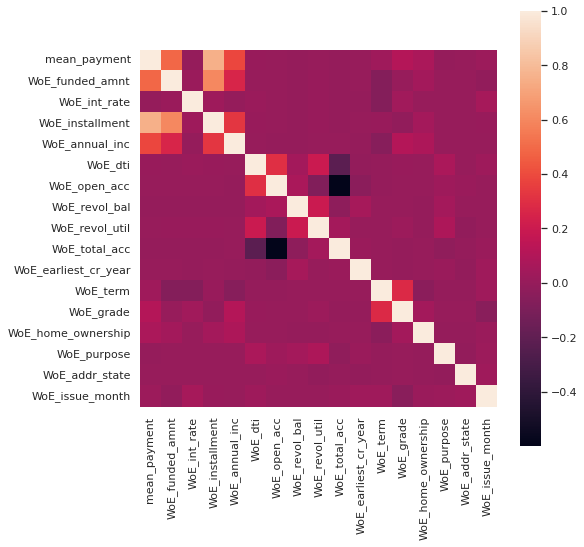

In [207]:
plt.figure(figsize=(8, 8))
correlations_woe = train.select_dtypes(include=['float64']).corr()

sns.heatmap(correlations_woe, square=True)

plt.show()

In [ ]:
for col in data.columns:
    if col == 'risk': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data, col, 'risk')

        print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: loan_amnt
      Value  All  Bad  Good  Distr_Good  Distr_Bad       WoE        IV
1517  30625    8    7     1    0.000005   0.000083 -2.844630  0.000223
1519   2225    7    6     1    0.000005   0.000071 -2.690479  0.000179
155   31025    5    4     1    0.000005   0.000048 -2.285014  0.000098
1069  31825    4    3     1    0.000005   0.000036 -1.997332  0.000062
639   30825    7    5     2    0.000010   0.000059 -1.815010  0.000090
...     ...  ...  ...   ...         ...        ...       ...       ...
472   20625   12    1    11    0.000053   0.000012  1.499176  0.000062
152   29050   13    1    12    0.000058   0.000012  1.586187  0.000073
718   20275   15    1    14    0.000068   0.000012  1.740338  0.000097
1413  25950   15    1    14    0.000068   0.000012  1.740338  0.000097
204    3025  173    9   164    0.000793   0.000107  2.003922  0.001375

[1522 rows x 8 columns]
IV score: 0.07


WoE and IV for column: funded_amnt
      Value  All  Bad  Good  Distr_Goo

# Логистическая регрессия

In [184]:
data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,installment_bin,annual_inc_bin,dti_bin,open_acc_bin,revol_bal_bin,revol_util_bin,total_acc_bin,risk_bin,mean_payment_bin,earliest_cr_year_bin
0,2500,2500,36 months,13.56,84.92,C,10+ years,RENT,55000.0,Not Verified,...,"(14.769, 230.74]","(44000.0, 60000.0]","(26.76, 999.0]","(10.0, 12.0]","(13270.0, 22084.0]","(25.3, 40.7]","(15.0, 20.0]","(-0.001, 1.0]","(27.776999999999997, 180.556]","(6.0, 14.0]"
1,30000,30000,60 months,18.94,777.23,D,10+ years,MORTGAGE,90000.0,Source Verified,...,"(659.43, 1618.24]","(76000.0, 105000.0]","(26.76, 999.0]","(16.0, 81.0]","(22084.0, 1044210.0]","(55.2, 71.8]","(34.0, 176.0]","(-0.001, 1.0]","(360.0, 533.333]","(6.0, 14.0]"
2,5000,5000,36 months,17.97,180.69,D,6 years,MORTGAGE,59280.0,Source Verified,...,"(14.769, 230.74]","(44000.0, 60000.0]","(15.75, 20.68]","(7.0, 10.0]","(22084.0, 1044210.0]","(25.3, 40.7]","(15.0, 20.0]","(-0.001, 1.0]","(27.776999999999997, 180.556]","(94.0, 99.0]"
3,4000,4000,36 months,18.94,146.51,D,10+ years,MORTGAGE,92000.0,Source Verified,...,"(14.769, 230.74]","(76000.0, 105000.0]","(-1.001, 10.69]","(10.0, 12.0]","(-0.001, 4638.0]","(-0.001, 25.3]","(20.0, 26.0]","(-0.001, 1.0]","(27.776999999999997, 180.556]","(-0.001, 3.0]"
4,30000,30000,60 months,16.14,731.78,C,10+ years,MORTGAGE,57250.0,Not Verified,...,"(659.43, 1618.24]","(44000.0, 60000.0]","(10.69, 15.75]","(16.0, 81.0]","(22084.0, 1044210.0]","(55.2, 71.8]","(34.0, 176.0]","(-0.001, 1.0]","(360.0, 533.333]","(94.0, 99.0]"


In [185]:
numeric_features = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
                    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'earliest_cr_year']

categorical = ['term', 'grade', 'home_ownership', 'purpose', 'addr_state', 'issue_month']  

# categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose',
#                'addr_state', 'issue_month']  # no loan_status & earliest_cr_year тк оно 1 в 1 к risk 


column_transformer = ColumnTransformer([
    # ('CleanCesius', SimpleImputer(strategy="mean"), numeric_features),
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

with mlflow.start_run(run_name="Логистическая регрессия"):

        x = data.drop(['risk'], axis=1)
        y = data['risk']

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

        model = pipeline.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        f1 = f1_score(y_test, y_pred_test, average='weighted')

        # M_test = mean_absolute_error(y_test, y_pred_test)
        # MS_test = mean_squared_error(y_test, y_pred_test)

        # mlflow.log_metric(" MAE test ", M_test)
        # mlflow.log_metric(" MSE test ", MS_test)


        mlflow.log_metric(" F1 ", f1)
        mlflow.log_param( " Average of F1", "weighted")

        mlflow.log_param( " Model name ", "LogisticRegression")

        mlflow.log_param( " Scaling type ", "StandardScaler")
        mlflow.log_param( " Encoding type ", "OneHotEncoder")

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
        else:
            mlflow.sklearn.log_model(model, "model")

# Дерево решений с бинарной целевой переменной

Для начала попробую все категориальные признаки закодировать с помощью **LabelEncoder** и посмотреть на небольшое дерево. LabelEncoder преобразует все категориальные признаки в числовые значения, что делает удобным работу с данными через деревья, но немного оторвано от здравого смысла, поскольку теперь моделью все категориальные признаки воспринимаются исключительно как диапазоны или с определенным приоритетом (например, 0 < 1 < 2), и это сложно интерпретировать обратно.

In [ ]:
labelencoder = LabelEncoder()

categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
               'earliest_cr_line', 'purpose',
               'verification_status', 'addr_state']
numeric_features = ['loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
                    'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
          'earliest_cr_line', 'purpose',
          'verification_status', 'addr_state', 
          'loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
          'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']]

y = data['risk']

for _ in categorical:
  x[_] = labelencoder.fit_transform(x[_])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

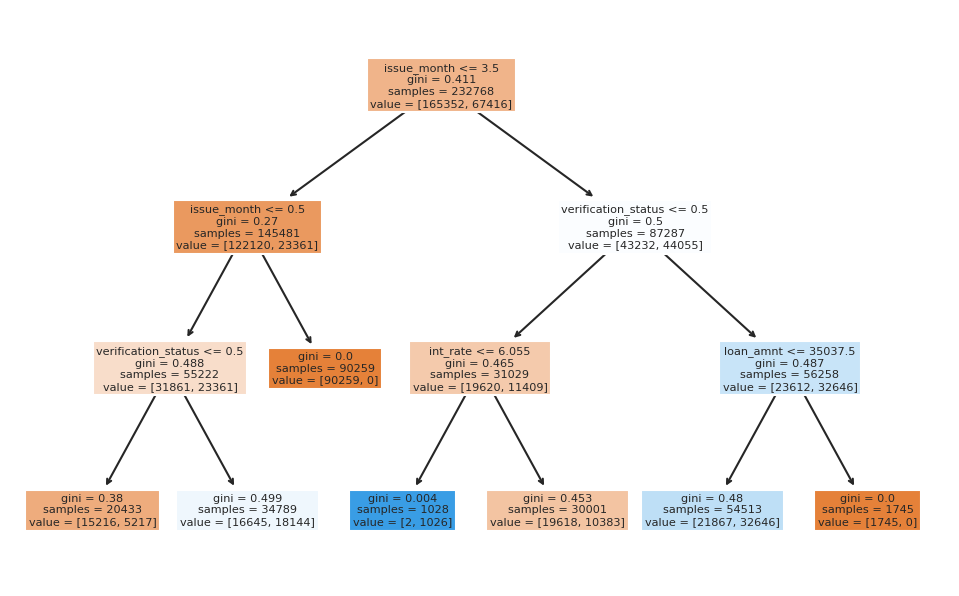

In [ ]:
plt.figure(figsize=(8, 5), dpi=150)
plot_tree(tree, feature_names = x.columns, filled=True)

plt.show()

Попробую еще другой, более наглядный вид визуализации:

In [ ]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 176 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=a760a5b70d18ff24dfb192dda35486174196b7a0672319895af039f2e522c07f
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


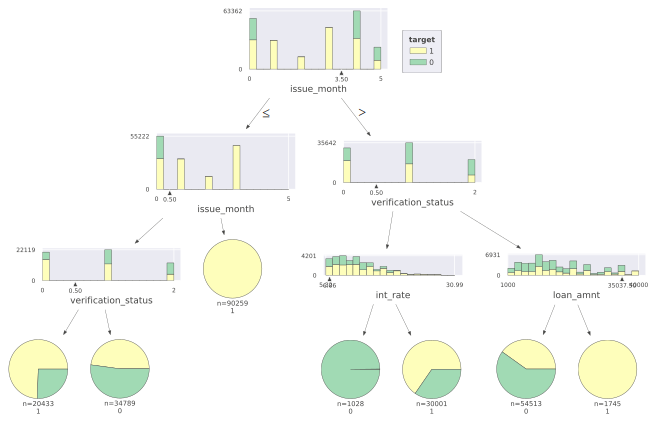

In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(tree, X_train, y_train,
                target_name = "target",
                feature_names = x.columns,
                class_names= ['1', '0'])

viz

In [ ]:
# print("Accuracy | train:", accuracy_score(y_train, tree.predict(X_train)))
# print("Accuracy | test:", accuracy_score(y_test, tree.predict(X_test)))

In [ ]:
y_train_score = tree.predict_proba(X_train)
y_test_score = tree.predict_proba(X_test)

Теперь попробую закодировать все категориальные с помощью **One Hot Encoding** и посмотреть на получшившиеся результаты. У данного вида кодирования есть плюсы: они более точно отражают изначальный "смысл" признаков, но и минусы - признаков становится очень много.

In [ ]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'issue_month', 
          'earliest_cr_line', 'purpose',
          'verification_status', 'addr_state', 
          'loan_amnt', 'annual_inc', 'int_rate', 'funded_amnt', 
          'installment', 'dti', 'open_acc', 'revol_util', 'total_acc']]

y = data['risk']

x = onehotencoder.fit_transform(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

new_tree = DecisionTreeClassifier(max_depth = 3)
new_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

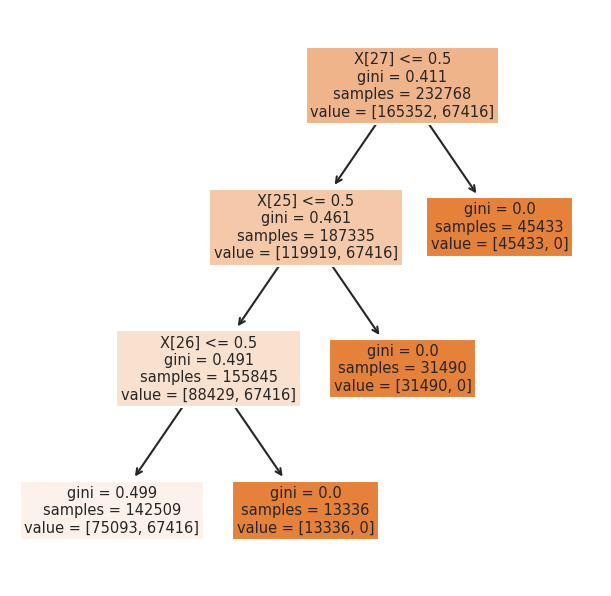

In [ ]:
plt.figure(figsize=(5, 5), dpi=150)
plot_tree(new_tree, filled=True)

plt.show()

In [ ]:
print("Accuracy | train:", accuracy_score(y_train, new_tree.predict(X_train)))
print("Accuracy | test:", accuracy_score(y_test, new_tree.predict(X_test)))

Accuracy | train: 0.7103725598020346
Accuracy | test: 0.7119412987816404


По качеству получилось, что OneHot кодирование даже немного проигрывает LabelEncoder, но оба значения метрики мне кажутся хорошими. 

С точки зрения наглядности построения дерева, у меня получилось хорошо отразить разделение с помощью Label, но с OneHot это почти нереально, потому что признаков получается слишком много для какой-то визуальной демонстрации (либо я плохо искала)

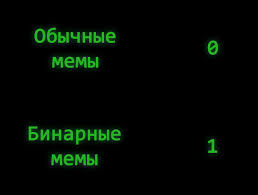

# Ridge-регрессия с параметрами по умолчанию


In [ ]:
categorical = ['term', 'grade', 'emp_length', 'home_ownership']
numeric_features = ['loan_amnt', 'int_rate', 'funded_amnt', 'installment', 'dti']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'loan_amnt', 
         'funded_amnt', 'int_rate', 'installment', 'dti']]

y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.4235
Test RMSE = 0.4237
